In [1]:
import pandas as pd
import numpy as np
import spacy

from sklearn.preprocessing import LabelEncoder

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
import re

# Download the NLTK resources required for preprocessing
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Define the stop words to be removed
stop_words = set(stopwords.words('english'))

# Create an instance of the WordNetLemmatizer and PorterStemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Define a function to perform the preprocessing
def preprocess_text(text):
    # Convert everything to lowercase
    text = text.lower()

    # remove everything that is not an alphabet
    text = re.sub('[^a-zA-Z]', ' ', text)

    # Tokenize the text into words
    words = word_tokenize(text)

    # Remove stop words
    words = [word for word in words if word not in stop_words]

    # Lemmatize the words
    words = [lemmatizer.lemmatize(word) for word in words]

    # Apply stemming
    words = [stemmer.stem(word) for word in words]

    # Join the words back into a string
    text = " ".join(words)

    return text

# Apply the preprocessing function to the 'text' column of the DataFrame 'df'
# df['article_claim_phase1'] = df['article_claim_phase1'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


<h1>Using the Kaggle2 (20k) Dataset<h1>

In [4]:
df2 = pd.read_csv('/content/drive/MyDrive/HiTS/Datasets/Kaggle20K/train.csv')

In [5]:
df2.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [6]:
df2.drop(['author', 'text'], inplace=True, axis=1)

In [7]:
df2.head()

,id,title,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",0
2,2,Why the Truth Might Get You Fired,1
3,3,15 Civilians Killed In Single US Airstrike Hav...,1
4,4,Iranian woman jailed for fictional unpublished...,1


In [8]:
df2.label.isna().sum()

0

In [9]:
df2.label.unique()

array([1, 0])

In [10]:
df2.isna().sum()

id         0
title    558
label      0
dtype: int64

In [11]:
df2 = df2.dropna()

In [12]:
df2.isna().sum()

id       0
title    0
label    0
dtype: int64

In [13]:
# During dropping of NaN values, some of the index is also removed so, reset index is necessary
df2.reset_index(inplace=True)

In [14]:
df2['title'] = df2['title'].apply(preprocess_text)
# filter out rows with length of string column less than 2 
df2 = df2[df2['title'].apply(lambda x: len(x.split(' ')) > 2)]

In [15]:
# During dropping of NaN values, some of the index is also removed so, reset index is necessary
df2.reset_index(inplace=True)

In [17]:
df2.drop(['level_0', 'index'], inplace=True, axis=1)

In [18]:
df2.head()

,id,title,label
0,0,hous dem aid even see comey letter jason chaff...,1
1,1,flynn hillari clinton big woman campu breitbart,0
2,2,truth might get fire,1
3,3,civilian kill singl u airstrik identifi,1
4,4,iranian woman jail fiction unpublish stori wom...,1


In [19]:
df2.shape

(19784, 3)

<h1>Spacy Word Embeddings<h1>

In [20]:
spacy.cli.download("en_core_web_lg")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [21]:
word_vectors = spacy.load('en_core_web_lg')

In [22]:
df2['vector'] = df2['title'].apply(lambda text: word_vectors(text).vector)  

In [23]:
df2.head()

,id,title,label,vector
0,0,hous dem aid even see comey letter jason chaff...,1,"[0.3708323, 0.9354641, -1.4037429, -0.431176, ..."
1,1,flynn hillari clinton big woman campu breitbart,0,"[0.7187071, 1.0618356, -1.0465229, 0.21339856,..."
2,2,truth might get fire,1,"[0.054802895, 2.50505, -3.905775, -0.330295, 0..."
3,3,civilian kill singl u airstrik identifi,1,"[-1.91155, 1.250995, -1.1590834, -0.026108345,..."
4,4,iranian woman jail fiction unpublish stori wom...,1,"[-1.101899, -1.008405, -1.2722199, -0.95129406..."


In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df2.vector.values,
    df2.label,
    test_size=0.2,
    random_state=20
)

In [25]:
X_train_2d = np.stack(X_train)
X_test_2d = np.stack(X_test)

In [26]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

# Define hyperparameters to search over
hyperparameters = {
    'alpha': [0.1, 1.0, 10.0],
}

scaler = MinMaxScaler()
scaled_train_embed = scaler.fit_transform(X_train_2d)
scaled_test_embed = scaler.transform(X_test_2d)


clf = MultinomialNB()
grid_search = GridSearchCV(clf, hyperparameters, cv=5)
grid_search.fit(scaled_train_embed, y_train)
# clf.fit(scaled_train_embed, y_train)

# Get the best model
spacy_best_model = grid_search.best_estimator_

# Print best hyperparameters and corresponding accuracy
print("Best hyperparameters: ", grid_search.best_params_)
print("Best accuracy: ", grid_search.best_score_)
print("Best model: ", spacy_best_model)

Best hyperparameters:  {'alpha': 0.1}
Best accuracy:  0.7372846565852227
Best model:  MultinomialNB(alpha=0.1)


In [27]:
from sklearn.metrics import classification_report
y_pred = spacy_best_model.predict(scaled_test_embed)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.82      0.65      0.73      2111
           1       0.68      0.84      0.75      1846

    accuracy                           0.74      3957
   macro avg       0.75      0.74      0.74      3957
weighted avg       0.75      0.74      0.74      3957



Text(95.72222222222221, 0.5, 'Truth')

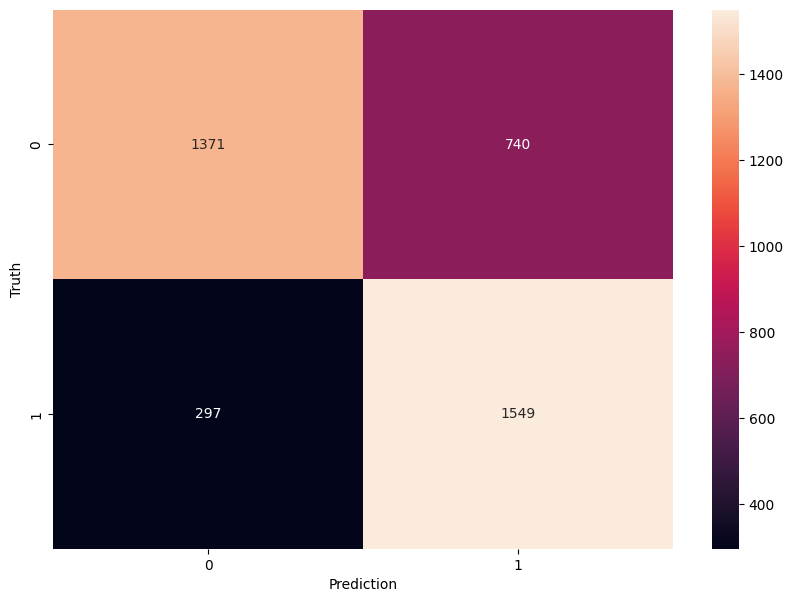

In [28]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

from matplotlib import pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')

<h1>Gensim Word Embeddings<h1>

In [29]:
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
# Save the model to a file
model_file = "/content/drive/MyDrive/HiTS/Datasets/gensim_word2vec_model.bin"
wv.save(model_file)



from gensim.models import KeyedVectors

# Load the saved Word2Vec model from the file
model_file = "/content/drive/MyDrive/HiTS/Datasets/gensim_word2vec_model.bin"
wv = KeyedVectors.load(model_file, mmap='r')


In [ ]:
# from gensim.models import KeyedVectors

# # Replace the path with the path where you saved the downloaded model file
# model_path = "/content/GoogleNews-vectors-negative300.bin.gz"

# # Load the model
# wv = KeyedVectors.load_word2vec_format(model_path, binary=True)


In [30]:
def preprocess_and_vectorize(text):
    # remove stop words and lemmatize the text
    doc = word_vectors(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)
        
    return wv.get_mean_vector(filtered_tokens)

In [31]:
df2['gensin_vector'] = df2['title'].apply(lambda text: preprocess_and_vectorize(text))

In [32]:
df2.head()

,id,title,label,vector,gensin_vector
0,0,hous dem aid even see comey letter jason chaff...,1,"[0.3708323, 0.9354641, -1.4037429, -0.431176, ...","[0.009824496, 0.036067843, -0.0157122, 0.02965..."
1,1,flynn hillari clinton big woman campu breitbart,0,"[0.7187071, 1.0618356, -1.0465229, 0.21339856,...","[0.04156037, 0.03780259, -0.026173955, 0.02537..."
2,2,truth might get fire,1,"[0.054802895, 2.50505, -3.905775, -0.330295, 0...","[0.11566126, 0.005249493, 0.061008282, -0.0377..."
3,3,civilian kill singl u airstrik identifi,1,"[-1.91155, 1.250995, -1.1590834, -0.026108345,...","[-0.0330815, 0.009606527, 0.051769227, 0.02384..."
4,4,iranian woman jail fiction unpublish stori wom...,1,"[-1.101899, -1.008405, -1.2722199, -0.95129406...","[0.01237844, -0.012353892, 0.022532538, 0.0288..."


In [50]:
X_train, X_test, y_train, y_test = train_test_split(
    df2.gensin_vector.values, 
    df2.label, 
    test_size=0.2, # 20% samples will go to test dataset
    random_state=20,
    stratify=df2.label
)

In [51]:
print("Shape of X_train before reshaping: ", X_train.shape)
print("Shape of X_test before reshaping: ", X_test.shape)


X_train_2d = np.stack(X_train)
X_test_2d =  np.stack(X_test)

print("Shape of X_train after reshaping: ", X_train_2d.shape)
print("Shape of X_test after reshaping: ", X_test_2d.shape)

Shape of X_train before reshaping:  (15827,)
Shape of X_test before reshaping:  (3957,)
Shape of X_train after reshaping:  (15827, 300)
Shape of X_test after reshaping:  (3957, 300)


In [38]:
from sklearn.ensemble import GradientBoostingClassifier
# Using Random forest instead of gradient boosting to save time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

#1. creating a GradientBoosting model object
# clf = GradientBoostingClassifier()
clf_rf = RandomForestClassifier()
#2. fit with all_train_embeddings and y_train
clf_rf.fit(X_train_2d, y_train)


#3. get the predictions for all_test_embeddings and store it in y_pred
y_pred = clf_rf.predict(X_test_2d)


#4. print the classfication report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.94      0.66      0.77      2078
           1       0.72      0.95      0.82      1879

    accuracy                           0.80      3957
   macro avg       0.83      0.81      0.80      3957
weighted avg       0.83      0.80      0.79      3957



Text(95.72222222222221, 0.5, 'Truth')

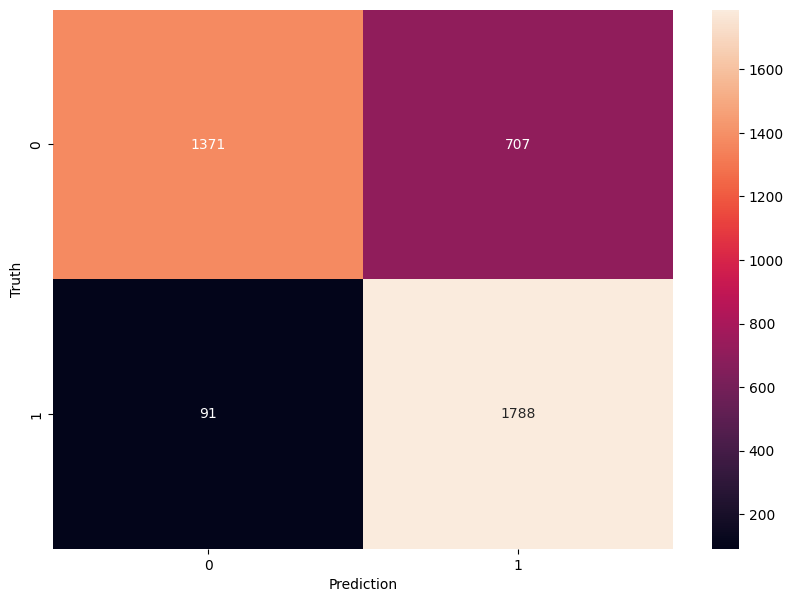

In [39]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)


from matplotlib import pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')

In [60]:
##########
from sklearn.model_selection import GridSearchCV

# Define a grid of hyperparameters to search over
# param_grid = {
#     'n_estimators': [50, 100],
#     'max_depth': [3, 5, 7],
# }
param_grid = {
    'n_estimators': [50], #11 mins 5
    'max_depth': [5, 7, 10], #5 mins
    'min_samples_split': [2], #9 mins 2
    'min_samples_leaf': [2], #9 min 2
    'bootstrap': [False] #8 mins False
}

# Create a Random Forest classifier object
clf = RandomForestClassifier()

# Create a GridSearchCV object and fit it to the training data
grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(X_train_2d, y_train)

# Print the best set of hyperparameters found
print("Best hyperparameters: ", grid_search.best_params_)
gensim_best_model = grid_search.best_estimator_

# Use the best set of hyperparameters to make predictions on the test set
y_pred = gensim_best_model.predict(X_test_2d)

# Print the classification report
print(classification_report(y_test, y_pred))


Best hyperparameters:  {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
              precision    recall  f1-score   support

           0       0.94      0.65      0.77      2078
           1       0.71      0.96      0.82      1879

    accuracy                           0.80      3957
   macro avg       0.83      0.81      0.79      3957
weighted avg       0.83      0.80      0.79      3957



Text(95.72222222222221, 0.5, 'Truth')

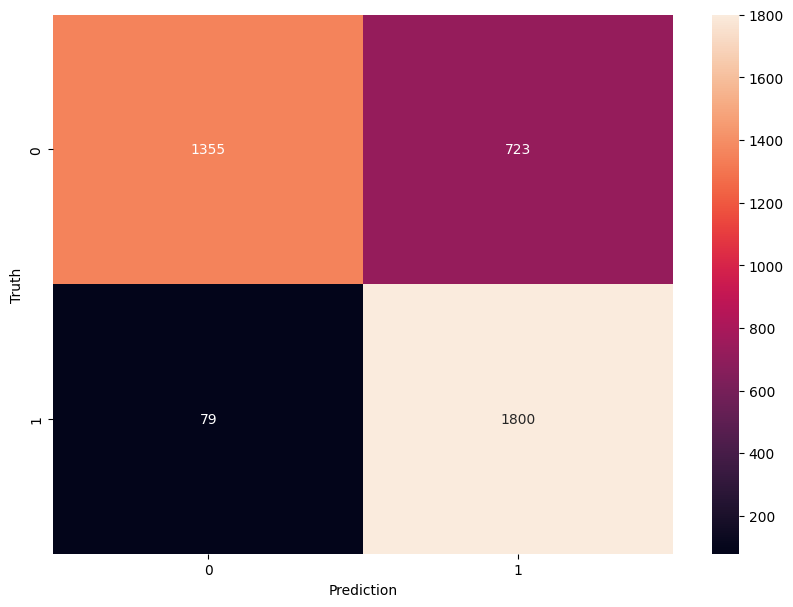

In [61]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)


from matplotlib import pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')

<h1>fasttext<h1>

In [ ]:
# import re

# def preprocess(text):
#     text = re.sub(r'[^\w\s\']',' ', text)
#     text = re.sub(' +', ' ', text)
#     return text.strip().lower() 

In [42]:
df2.head()

,id,title,label,vector,gensin_vector
0,0,hous dem aid even see comey letter jason chaff...,1,"[0.3708323, 0.9354641, -1.4037429, -0.431176, ...","[0.009824496, 0.036067843, -0.0157122, 0.02965..."
1,1,flynn hillari clinton big woman campu breitbart,0,"[0.7187071, 1.0618356, -1.0465229, 0.21339856,...","[0.04156037, 0.03780259, -0.026173955, 0.02537..."
2,2,truth might get fire,1,"[0.054802895, 2.50505, -3.905775, -0.330295, 0...","[0.11566126, 0.005249493, 0.061008282, -0.0377..."
3,3,civilian kill singl u airstrik identifi,1,"[-1.91155, 1.250995, -1.1590834, -0.026108345,...","[-0.0330815, 0.009606527, 0.051769227, 0.02384..."
4,4,iranian woman jail fiction unpublish stori wom...,1,"[-1.101899, -1.008405, -1.2722199, -0.95129406...","[0.01237844, -0.012353892, 0.022532538, 0.0288..."


In [43]:
df2['label1'] = '__label__' + df2['label'].apply(lambda text: str(text))  
df2['fasttext_input'] = df2['label1'] + ' ' + df2['title'] 

In [44]:
df2.head()
# df2.drop('fasttext_input', axis=1, inplace=True)

,id,title,label,vector,gensin_vector,label1,fasttext_input
0,0,hous dem aid even see comey letter jason chaff...,1,"[0.3708323, 0.9354641, -1.4037429, -0.431176, ...","[0.009824496, 0.036067843, -0.0157122, 0.02965...",__label__1,__label__1 hous dem aid even see comey letter ...
1,1,flynn hillari clinton big woman campu breitbart,0,"[0.7187071, 1.0618356, -1.0465229, 0.21339856,...","[0.04156037, 0.03780259, -0.026173955, 0.02537...",__label__0,__label__0 flynn hillari clinton big woman cam...
2,2,truth might get fire,1,"[0.054802895, 2.50505, -3.905775, -0.330295, 0...","[0.11566126, 0.005249493, 0.061008282, -0.0377...",__label__1,__label__1 truth might get fire
3,3,civilian kill singl u airstrik identifi,1,"[-1.91155, 1.250995, -1.1590834, -0.026108345,...","[-0.0330815, 0.009606527, 0.051769227, 0.02384...",__label__1,__label__1 civilian kill singl u airstrik iden...
4,4,iranian woman jail fiction unpublish stori wom...,1,"[-1.101899, -1.008405, -1.2722199, -0.95129406...","[0.01237844, -0.012353892, 0.022532538, 0.0288...",__label__1,__label__1 iranian woman jail fiction unpublis...


In [45]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df2, test_size=0.2)



In [46]:
train.shape, test.shape

((15827, 7), (3957, 7))

In [47]:
train.to_csv("fasttext.train", columns=["fasttext_input"], index=False, header=False)
test.to_csv("fasttext.test", columns=["fasttext_input"], index=False, header=False)


In [48]:
!pip install fasttext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 KB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.10.4-py3-none-any.whl (222 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp39-cp39-linux_x86_64.whl size=4395714 sha256=f71b883749cc9091a7ac11b88a8aa9d3719c5632f6e8b702f8f910aa93531f43
  Stored in directory: /root/.cache/pip/wheels/64/57/bc/1741406019061d5664914b070bd3e71f6244648732bc96109e
Successfully built fasttext


In [49]:
import fasttext

model = fasttext.train_supervised(input="fasttext.train")
model.test("fasttext.test")

(3957, 0.9327773565832701, 0.9327773565832701)

In [ ]:
model.predict("thunderstorm today")

(('__label__1',), array([1.00000942]))